In [1]:
import mediapipe as mp
import numpy as np
import cv2
import math
import pandas as pd
import time
import os 
import random
import matplotlib.pyplot as plt
from PIL import Image

c:\Users\whisn\anaconda3\envs\bangkitcourse\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
chosen_left_eye_idxs  = [362, 385, 387, 263, 373, 380]
chosen_right_eye_idxs = [33,  160, 158, 133, 153, 144]

In [3]:
facemesh =  mp.solutions.face_mesh
face = facemesh.FaceMesh(
    static_image_mode=False, 
    min_tracking_confidence=0.5, 
    min_detection_confidence=0.5
    )
draw = mp.solutions.drawing_utils

In [309]:
def calculate_font_parameters(frame, base_font_scale=0.002, base_thickness=0.005):
    frame_height, frame_width = frame.shape[:2]
    font_scale = frame_height * base_font_scale
    thickness = int(frame_height * base_thickness)
    
    return font_scale, thickness

def putText(frame, val, x, y, unity=""):
    font_scale, thickness = calculate_font_parameters(frame, 0.002, 0.005)
    
    if len(unity) == 0:
        cv2.putText(frame, f'{val}', (x, y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 255, 0), thickness)
    else:
        cv2.putText(frame, f'{val:.3f} {unity}', (x, y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 255, 0), thickness)            
                
def getTargettedLandmark():
    targetted_landmark = []
    targetted_landmark.append(chosen_left_eye_idxs)
    targetted_landmark.append(chosen_right_eye_idxs)
    return targetted_landmark   

def drawEyeText(frame, val, x, w, y, h):
    font_scale, thickness = calculate_font_parameters(frame, 0.0005, 0.003)
    
    cv2.putText(
        frame, text=f'p{val}', org=(int(x * w), int(y * h)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=font_scale, color=(0, 255, 0),
        thickness=thickness, lineType=cv2.LINE_AA
    )

def eucDist(point1, point2):
    return math.sqrt((point2.x - point1.x)**2 + (point2.y - point1.y)**2)

def eyeAspectRatio(right_eye, left_eye):
    right_eye = (eucDist(right_eye[2], right_eye[5]) + eucDist(right_eye[4], right_eye[3]))/(2*eucDist(right_eye[0], right_eye[1]))
    left_eye = (eucDist(left_eye[4], left_eye[3]) + eucDist(left_eye[5], left_eye[2]))/(2*eucDist(left_eye[1], left_eye[0]))
    return right_eye, left_eye

def eyeAnalysis(right_eye, left_eye):
    thresh_ear = 0.29
    eye_status = None
    avgEAR = (left_eye + right_eye) / 2
    if(right_eye < thresh_ear and left_eye < thresh_ear):
    # if avgEAR < thresh_ear:
        # ear_msg = f'! Drowsiness Detected ! - EAR Score : {str(avgEAR)}'
        # print(ear_msg)
        eye_status = 'Mata Tertutup'
    else: 
        eye_status = 'Mata Terbuka'
    return eye_status

In [121]:
def get_image_samples(directory, sample_size=5):
    all_files = os.listdir(directory)

    image_files = [f for f in all_files if f.lower().endswith(('png', 'jpg', 'jpeg', 'gif', 'bmp'))]
    if len(image_files) < sample_size:
        raise ValueError(f"Not enough images to sample. Found {len(image_files)} images, but need {sample_size}.")
    
    sampled_images = random.sample(image_files, sample_size)
    loaded_images = [cv2.imread(os.path.join(directory, img)) for img in sampled_images]
    loaded_images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in loaded_images]
    
    return loaded_images

def display_images(images):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    if len(images) == 1:
        axes = [axes]
    for ax, img in zip(axes, images):
        ax.imshow(img)
        ax.axis('off')  # Hide axes
    plt.show()
    
def get_random_file_path(directory):
    try:
        files = os.listdir(directory)

        files = [f for f in files if os.path.isfile(os.path.join(directory, f))]        
        if not files:
            return "No files found in the directory."

        random_file = random.choice(files)
        random_file_path = os.path.join(directory, random_file)

        return random_file_path
    except Exception as e:
        return f"An error occurred: {e}"
    
def check_and_create_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"Directory {path} created.")
    else:
        print(f"Directory {path} already exists.")

# ganti workpath sesuai dengan directory anda !!

In [126]:
work_path = 'C:/Users/whisn/Downloads/[01] Whisnumury/[05] Project/[02] Diware Levelup/Milestone 1 - Testing Mata'

dataset_dir = f'{work_path}/Datasets'
annot_dir = f'{work_path}/Annotations Result'
result_dir = f'{work_path}/Result'

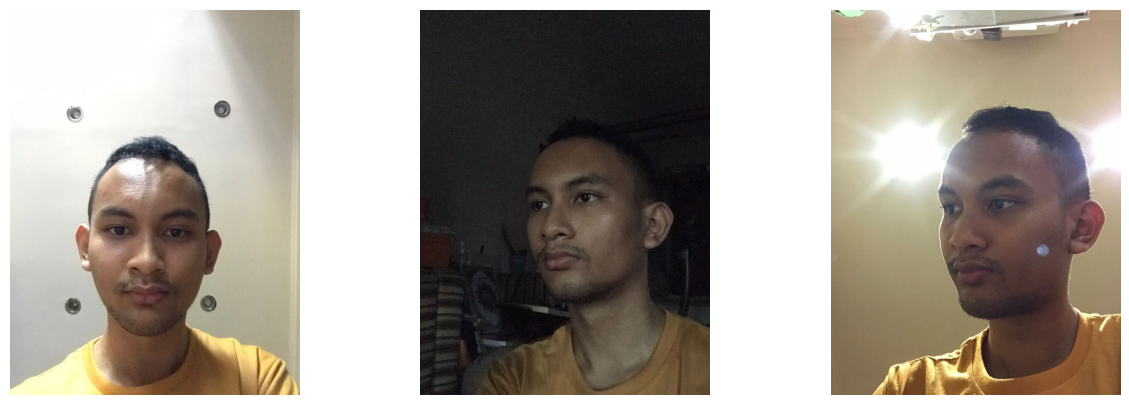

In [50]:
sampled_images = get_image_samples(f'{dataset_dir}/dataset/Internal/Mata/Terbuka', 3)
display_images(sampled_images)

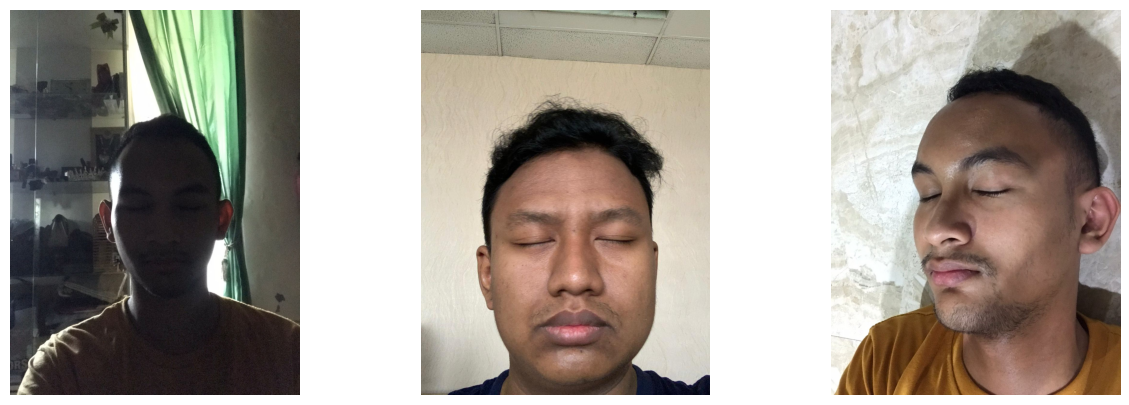

In [49]:
sampled_images = get_image_samples(f'{dataset_dir}/dataset/Internal/Mata/Tertutup', 3)
display_images(sampled_images)

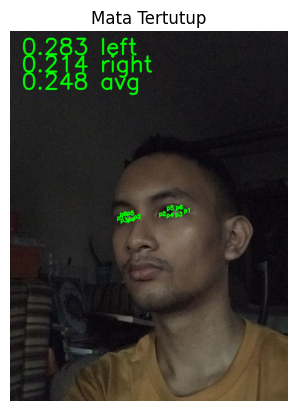

In [258]:
# image = None
image = cv2.cvtColor(sampled_images[1], cv2.COLOR_BGR2RGB)
img_h, img_w, _ = image.shape
op = face.process(image)

if op.multi_face_landmarks:
    for pt in op.multi_face_landmarks:
        eye_store = [[], []]
        # thickness
        left_eye, right_eye, mouth, head = [1, 1, 1, 1]
        
        for no, point in enumerate(pt.landmark):
            if no in chosen_left_eye_idxs:
                drawEyeText(image, left_eye, point.x, img_w, point.y, img_h)
                eye_store[0].append(point)
                left_eye += 1
            if no in chosen_right_eye_idxs:
                drawEyeText(image, right_eye, point.x, img_w, point.y, img_h)
                eye_store[1].append(point)
                right_eye += 1
                
        if len(eye_store[0]) > 1:
            right_eye, left_eye = eyeAspectRatio(eye_store[0], eye_store[1])
            
        avg_ear = (right_eye+left_eye)/2 
        putText(image, left_eye, 50, 100, "left")
        putText(image, right_eye, 50, 175, "right")
        putText(image, avg_ear, 50, 250, "avg")
        
        eye_status = eyeAnalysis(right_eye, left_eye)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    plt.imshow(image)
    plt.axis('off')  # Hide axes for cleaner presentation
    plt.title(f'{eye_status}')
    plt.show()

In [244]:
def detect_drowsiness(image_path):
    image = cv2.imread(image_path)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_h, img_w, _ = image.shape
    op = face.process(image)

    if op.multi_face_landmarks:
        for pt in op.multi_face_landmarks:
            eye_store = [[], []]
            # thickness
            left_eye, right_eye, mouth, head = [1, 1, 1, 1]
            eye_status = None
            
            for no, point in enumerate(pt.landmark):
                if no in chosen_left_eye_idxs:
                    drawEyeText(image, left_eye, point.x, img_w, point.y, img_h)
                    eye_store[0].append(point)
                    left_eye += 1
                if no in chosen_right_eye_idxs:
                    drawEyeText(image, right_eye, point.x, img_w, point.y, img_h)
                    eye_store[1].append(point)
                    right_eye += 1
                    
            if len(eye_store[0]) > 1:
                right_eye, left_eye = eyeAspectRatio(eye_store[0], eye_store[1])
                
            avg_ear = (right_eye+left_eye)/2 
            putText(image, left_eye, 50, 100, "left")
            putText(image, right_eye, 50, 175, "right")
            putText(image, avg_ear, 50, 250, "avg")
            
            eye_status = eyeAnalysis(right_eye, left_eye)
            putText(image, f'pred: {eye_status}', 50, 325)
        
        saved_image = image
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        try:
            cv2.imwrite('tes.jpg', saved_image)
        except:
            print('image not saved')
        plt.imshow(image)
        plt.axis('off')  # Hide axes for cleaner presentation
        plt.title(f'{eye_status}')
        plt.show()

# Check Recheck Dataset

In [62]:
def count_files_in_directory(directory):
    file_count = 0
    for root, dirs, files in os.walk(directory):
        file_count += len(files)
    
    return file_count

In [63]:
print('Open Eye: ', count_files_in_directory(f'{dataset_dir}/dataset-combine/Mata/Terbuka'))
print('Close Eye: ', count_files_in_directory(f'{dataset_dir}/dataset-combine/Mata/Tertutup'))

Open Eye:  453
Close Eye:  460


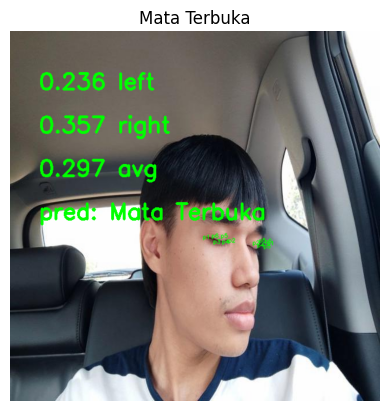

In [275]:
detect_drowsiness(
    f'{get_random_file_path(f"{dataset_dir}/dataset-combine/Mata/Tertutup/")}'
)

# Testing Flow

In [112]:
origin_paths = []
detect_paths = []
image_names = []
left_eyes = []
right_eyes = []
avg_eyes = []
truths = []
detected = []

In [297]:
def detect_drowsiness(image_path):
    image = cv2.imread(image_path)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_h, img_w, _ = image.shape
    print(img_h, img_w)
    op = face.process(image)

    if op.multi_face_landmarks:
        print('landmark detected')
        for pt in op.multi_face_landmarks:
            eye_store = [[], []]
            # thickness
            left_eye, right_eye, mouth, head = [1, 1, 1, 1]
            eye_status = None
            
            for no, point in enumerate(pt.landmark):
                if no in chosen_left_eye_idxs:
                    drawEyeText(image, left_eye, point.x, img_w, point.y, img_h)
                    eye_store[0].append(point)
                    left_eye += 1
                if no in chosen_right_eye_idxs:
                    drawEyeText(image, right_eye, point.x, img_w, point.y, img_h)
                    eye_store[1].append(point)
                    right_eye += 1
                    
            if len(eye_store[0]) > 1:
                right_eye, left_eye = eyeAspectRatio(eye_store[0], eye_store[1])
                
            avg_ear = (right_eye+left_eye)/2 
            putText(image, left_eye, 50, 100, "left")
            putText(image, right_eye, 50, 175, "right")
            putText(image, avg_ear, 50, 250, "avg")
            
            eye_status = eyeAnalysis(right_eye, left_eye)
            putText(image, f'pred: {eye_status}', 50, 325)

        # detect_path = f'./detect/Mata/Terbuka/tes.jpg'
        # cv2.imwrite(f'{detect_path}', image)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        return right_eye, left_eye, avg_ear, eye_status, image

    else:
        print(f'No Face Detected\n{image_path}')

In [284]:
print('Open Eye: ', count_files_in_directory(f'{dataset_dir}/dataset-combine/Mata/Terbuka'))
print('Close Eye: ', count_files_in_directory(f'{dataset_dir}/dataset-combine/Mata/Tertutup'))

Open Eye:  453
Close Eye:  460


1. Combine Dataset [done]
2. Iterate Dataset
3. Predict
4. Save Image after Predict
5. Store Data
6. Testing Report

# Build Testing

In [305]:
detect_drowsiness(get_random_file_path(f'{dataset_dir}/dataset-combine/Mata/Terbuka'))

480 640
No Face Detected
C:/Users/whisn/Downloads/[01] Whisnumury/[05] Project/[02] Diware Levelup/Milestone 1 - Testing Mata/Datasets/dataset-combine/Mata/Terbuka\32.jpg


In [318]:
def run_testing(input_dataset, annot_dirname):
    i = 0
    for root, dirs, files in os.walk(input_dataset):
        for file_name in files:
            truth_label = root.split('\\')[-1]
            file_path = os.path.join(root, file_name).replace('\\', '/')
            
            try:
                right_eye, left_eye, avg_ear, predicted_label, img = detect_drowsiness(file_path)
                right_eyes.append(right_eye)
                left_eyes.append(left_eye)
                avg_eyes.append(avg_ear)
                origin_paths.append(file_path)
                image_names.append(file_name)
                truths.append(truth_label)
                detected.append(eye_status.split()[-1])

                try:
                    # print(truth_label)
                    # print(detect_path)
                    save_dir = f'{annot_dir}/{annot_dirname}/Mata/{predicted_label}'
                    check_and_create_directory(save_dir)
                    detect_path = f'{save_dir}/{file_name}'
                    
                    image = Image.fromarray(img)
                    image.save(f'{detect_path}')
                except FileNotFoundError:
                    print('File path not found, image not saved')
                except Exception as e:
                    print(f'Error occurred: {str(e)}')
                    print('Image not saved')
                detect_paths.append(detect_path)
            except:
                err_val = None
                right_eyes.append(err_val)
                left_eyes.append(err_val)
                avg_eyes.append(err_val)
                origin_paths.append(file_path)
                image_names.append(file_name)
                truths.append(truth_label)
                detected.append(err_val)
                print(f'cannot detect image: {i}')
                i += 1
                detect_paths.append(err_val)

In [310]:
origin_paths = []
detect_paths = []
image_names = []
left_eyes = []
right_eyes = []
avg_eyes = []
truths = []
detected = []


input_dir = f'{dataset_dir}/dataset-combine'
annot_dirname = 'Default'
if os.path.isdir(input_dir):
    run_testing(input_dir, annot_dirname)
else:
    print("Path yang dimasukkan bukan direktori yang valid.")

cannot detect image: 0
218 178
landmark detected
Directory C:/Users/whisn/Downloads/[01] Whisnumury/[05] Project/[02] Diware Levelup/Milestone 1 - Testing Mata/Annotations Result/Default/Mata/Mata Tertutup created.
218 178
No Face Detected
C:/Users/whisn/Downloads/[01] Whisnumury/[05] Project/[02] Diware Levelup/Milestone 1 - Testing Mata/Datasets/dataset-combine/Mata/Terbuka/10.jpg
cannot detect image: 1
1357 1971
landmark detected
Directory C:/Users/whisn/Downloads/[01] Whisnumury/[05] Project/[02] Diware Levelup/Milestone 1 - Testing Mata/Annotations Result/Default/Mata/Mata Terbuka created.
1357 1971
landmark detected
Directory C:/Users/whisn/Downloads/[01] Whisnumury/[05] Project/[02] Diware Levelup/Milestone 1 - Testing Mata/Annotations Result/Default/Mata/Mata Terbuka already exists.
740 941
landmark detected
Directory C:/Users/whisn/Downloads/[01] Whisnumury/[05] Project/[02] Diware Levelup/Milestone 1 - Testing Mata/Annotations Result/Default/Mata/Mata Tertutup already exists.

c:\Users\whisn\anaconda3\envs\bangkitcourse\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


218 178
No Face Detected
C:/Users/whisn/Downloads/[01] Whisnumury/[05] Project/[02] Diware Levelup/Milestone 1 - Testing Mata/Datasets/dataset-combine/Mata/Terbuka/11.jpg
cannot detect image: 3
480 640
landmark detected
Directory C:/Users/whisn/Downloads/[01] Whisnumury/[05] Project/[02] Diware Levelup/Milestone 1 - Testing Mata/Annotations Result/Default/Mata/Mata Terbuka already exists.
480 640
landmark detected
Directory C:/Users/whisn/Downloads/[01] Whisnumury/[05] Project/[02] Diware Levelup/Milestone 1 - Testing Mata/Annotations Result/Default/Mata/Mata Terbuka already exists.
480 640
landmark detected
Directory C:/Users/whisn/Downloads/[01] Whisnumury/[05] Project/[02] Diware Levelup/Milestone 1 - Testing Mata/Annotations Result/Default/Mata/Mata Terbuka already exists.
480 640
landmark detected
Directory C:/Users/whisn/Downloads/[01] Whisnumury/[05] Project/[02] Diware Levelup/Milestone 1 - Testing Mata/Annotations Result/Default/Mata/Mata Terbuka already exists.
480 640
landma

In [311]:
print(origin_paths[-1])
print(detect_paths[-1])
print(image_names[-1])
print(left_eyes[-1])
print(right_eyes[-1])
print(avg_eyes[-1])
print(truths[-1])
print(detected[-1])

C:/Users/whisn/Downloads/[01] Whisnumury/[05] Project/[02] Diware Levelup/Milestone 1 - Testing Mata/Datasets/dataset-combine/Mata/Tertutup/99.jpg
C:/Users/whisn/Downloads/[01] Whisnumury/[05] Project/[02] Diware Levelup/Milestone 1 - Testing Mata/Annotations Result/Default/Mata/Mata Tertutup/99.jpg
99.jpg
0.13068706922853707
0.14793866048773946
0.13931286485813826
Tertutup
Tertutup


In [20]:
print(len(origin_paths))
print(len(detect_paths))
print(len(image_names))
print(len(left_eyes))
print(len(right_eyes))
print(len(avg_eyes))
print(len(truths))
print(len(detected))

913
913
913
913
913
913
913
913


In [327]:
df = pd.DataFrame({
    'origin_path': origin_paths,
    'detect_path': detect_paths,
    'image_names': origin_paths,
    'left_eye': left_eyes,
    'right_eye': right_eyes,
    'avg_eye': avg_eyes,
    'truth': truths,
    'detected': detected
})

In [328]:
display(
    df.head(),
    df.isnull().sum(),
)

,origin_path,detect_path,image_names,left_eye,right_eye,avg_eye,truth,detected
0,C:/Users/whisn/Downloads/[01] Whisnumury/[05] ...,None,C:/Users/whisn/Downloads/[01] Whisnumury/[05] ...,NaN,NaN,NaN,Terbuka,None
1,C:/Users/whisn/Downloads/[01] Whisnumury/[05] ...,C:/Users/whisn/Downloads/[01] Whisnumury/[05] ...,C:/Users/whisn/Downloads/[01] Whisnumury/[05] ...,0.439963,0.483657,0.461810,Terbuka,Tertutup
2,C:/Users/whisn/Downloads/[01] Whisnumury/[05] ...,C:/Users/whisn/Downloads/[01] Whisnumury/[05] ...,C:/Users/whisn/Downloads/[01] Whisnumury/[05] ...,0.230202,0.318786,0.274494,Terbuka,Tertutup
3,C:/Users/whisn/Downloads/[01] Whisnumury/[05] ...,C:/Users/whisn/Downloads/[01] Whisnumury/[05] ...,C:/Users/whisn/Downloads/[01] Whisnumury/[05] ...,0.266652,0.367490,0.317071,Terbuka,Tertutup
4,C:/Users/whisn/Downloads/[01] Whisnumury/[05] ...,C:/Users/whisn/Downloads/[01] Whisnumury/[05] ...,C:/Users/whisn/Downloads/[01] Whisnumury/[05] ...,0.313893,0.251680,0.282786,Terbuka,Tertutup


origin_path     0
detect_path    96
image_names     0
left_eye       96
right_eye      96
avg_eye        96
truth           0
detected       96
dtype: int64

: 

In [315]:
df.to_csv(f'{result_dir}/result-detection3.csv', index=False)

# Kurasi Dataset

In [319]:
origin_paths = []
detect_paths = []
image_names = []
left_eyes = []
right_eyes = []
avg_eyes = []
truths = []
detected = []


input_dir = f'{dataset_dir}/dataset-kurasi'
annot_dirname = 'Dataset Kurasi'
if os.path.isdir(input_dir):
    run_testing(input_dir, annot_dirname)
else:
    print("Path yang dimasukkan bukan direktori yang valid.")

218 178
No Face Detected
C:/Users/whisn/Downloads/[01] Whisnumury/[05] Project/[02] Diware Levelup/Milestone 1 - Testing Mata/Datasets/dataset-kurasi/Mata/Terbuka/10.jpg
cannot detect image: 0
1357 1971
landmark detected
Directory C:/Users/whisn/Downloads/[01] Whisnumury/[05] Project/[02] Diware Levelup/Milestone 1 - Testing Mata/Annotations Result/Dataset Kurasi/Mata/Mata Terbuka created.
740 941
landmark detected
Directory C:/Users/whisn/Downloads/[01] Whisnumury/[05] Project/[02] Diware Levelup/Milestone 1 - Testing Mata/Annotations Result/Dataset Kurasi/Mata/Mata Tertutup created.
1504 1505
landmark detected
Directory C:/Users/whisn/Downloads/[01] Whisnumury/[05] Project/[02] Diware Levelup/Milestone 1 - Testing Mata/Annotations Result/Dataset Kurasi/Mata/Mata Terbuka already exists.
875 683
landmark detected
Directory C:/Users/whisn/Downloads/[01] Whisnumury/[05] Project/[02] Diware Levelup/Milestone 1 - Testing Mata/Annotations Result/Dataset Kurasi/Mata/Mata Tertutup already exi

c:\Users\whisn\anaconda3\envs\bangkitcourse\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


640 640
No Face Detected
C:/Users/whisn/Downloads/[01] Whisnumury/[05] Project/[02] Diware Levelup/Milestone 1 - Testing Mata/Datasets/dataset-kurasi/Mata/Terbuka/123.jpg
cannot detect image: 1
640 640
landmark detected
Directory C:/Users/whisn/Downloads/[01] Whisnumury/[05] Project/[02] Diware Levelup/Milestone 1 - Testing Mata/Annotations Result/Dataset Kurasi/Mata/Mata Terbuka already exists.
640 640
No Face Detected
C:/Users/whisn/Downloads/[01] Whisnumury/[05] Project/[02] Diware Levelup/Milestone 1 - Testing Mata/Datasets/dataset-kurasi/Mata/Terbuka/126.jpg
cannot detect image: 2
640 640
No Face Detected
C:/Users/whisn/Downloads/[01] Whisnumury/[05] Project/[02] Diware Levelup/Milestone 1 - Testing Mata/Datasets/dataset-kurasi/Mata/Terbuka/127.jpg
cannot detect image: 3
640 640
No Face Detected
C:/Users/whisn/Downloads/[01] Whisnumury/[05] Project/[02] Diware Levelup/Milestone 1 - Testing Mata/Datasets/dataset-kurasi/Mata/Terbuka/128.jpg
cannot detect image: 4
640 640
landmark de

In [321]:
print(len(origin_paths))
print(len(detect_paths))
print(len(image_names))
print(len(left_eyes))
print(len(right_eyes))
print(len(avg_eyes))
print(len(truths))
print(len(detected))

763
763
763
763
763
763
763
763


In [326]:
df = pd.DataFrame({
    'origin_path': origin_paths,
    'detect_path': detect_paths,
    'image_names': origin_paths,
    'left_eye': left_eyes,
    'right_eye': right_eyes,
    'avg_eye': avg_eyes,
    'truth': truths,
    'detected': detected
})

In [325]:
display(
    df.head(),
    df.isnull().sum(),
)

,origin_path,detect_path,image_names,left_eye,right_eye,avg_eye,truth,detected
0,C:/Users/whisn/Downloads/[01] Whisnumury/[05] ...,None,C:/Users/whisn/Downloads/[01] Whisnumury/[05] ...,NaN,NaN,NaN,Terbuka,None
1,C:/Users/whisn/Downloads/[01] Whisnumury/[05] ...,C:/Users/whisn/Downloads/[01] Whisnumury/[05] ...,C:/Users/whisn/Downloads/[01] Whisnumury/[05] ...,0.439963,0.483657,0.461810,Terbuka,Tertutup
2,C:/Users/whisn/Downloads/[01] Whisnumury/[05] ...,C:/Users/whisn/Downloads/[01] Whisnumury/[05] ...,C:/Users/whisn/Downloads/[01] Whisnumury/[05] ...,0.230202,0.318786,0.274494,Terbuka,Tertutup
3,C:/Users/whisn/Downloads/[01] Whisnumury/[05] ...,C:/Users/whisn/Downloads/[01] Whisnumury/[05] ...,C:/Users/whisn/Downloads/[01] Whisnumury/[05] ...,0.266652,0.367490,0.317071,Terbuka,Tertutup
4,C:/Users/whisn/Downloads/[01] Whisnumury/[05] ...,C:/Users/whisn/Downloads/[01] Whisnumury/[05] ...,C:/Users/whisn/Downloads/[01] Whisnumury/[05] ...,0.313893,0.251680,0.282786,Terbuka,Tertutup


origin_path     0
detect_path    96
image_names     0
left_eye       96
right_eye      96
avg_eye        96
truth           0
detected       96
dtype: int64

In [324]:
df.to_csv(f'{result_dir}/result-kurasi.csv', index=False)